In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import stats
from tqdm.notebook import trange

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator

from function.seqfilter import SeqFilter
from function.conserve import ConserveByWeb
from function.conserve import ConservePeraa
from function.conserve import ConserveStandalone
from function.utilities import get_taxid_dict
from function.utilities import get_protein_name
from function.utilities import get_uniprot_rawdata
from function.utilities import find_human_sequence

# Param

In [2]:
zz = ['Q13148','P35637', 'P49790', 'Q8NDV7']

In [3]:
#####CHANGE HERE#####
uniprot_id = "Q13148"
algorithm = "VSL2" #VLXT, VSL2, VL3-BA
conserve_method = 'jsd' #['r4s','shannon_entropy','jsd']
#####CHANGE HERE#####

In [4]:
#path concat
input_path = Path("./output/fasta/d_extre_filtered")
output_path = Path("./output/fig2_conservation") / Path(conserve_method)
output_path.mkdir(parents=True, exist_ok=True)

#see tax
tax_ids = [7711, 7742, 32523, 40674]

#disorder/order length criteria
disorder_filter_length = 40
order_filter_length = 10

#conserve_method config
windows_size = 0
sequence_weight = False
normalize = True


conserve_peraa_sort = ["A","C","D","E","G","H","I","K","L","M","N","P","Q","R","S","T","V","F","W","Y"]

# Load uniprot and PONDR identified data

In [5]:
human_uniprot_path = Path("./rawdata/human_uniprot.tab")
human_df = get_uniprot_rawdata(human_uniprot_path)

pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")
od_human_df = pd.read_pickle(pondr_disorder_ident_path / "{}_od_human_df.pkl".format(algorithm))

# Conservation Score

In [6]:
def get_only_human_score(score, fasta_path):
    """
    get entropy score only when alignment positions on human sequence is not gap

    score: list, entropy score calculated by Entropy().alied_entropy()
    fasta_path: str, fasta file 
    
    return: list, score as same length with human sequence
    """
    nogap_score = []
    nogap = np.array(list(find_human_sequence(fasta_path)["sequence"])) != "-"
    nogap_index = np.where(nogap)[0].tolist()
    for index in nogap_index:
        nogap_score.append(score[index])
    return nogap_score


def get_normalize_by_chordata(conserve_list):    
    
    #get mean and std
    z_score_base = np.array(conserve_list[0]['score'])
    mean = z_score_base.mean()
    std = z_score_base.std()
    
    #get z-score
    score = np.stack([i['score'] for i in conserve_list])
    score = (score - mean) / std
    
    #put back to conserve_list
    for index, element in enumerate(score):
        element = element.tolist()
        conserve_list[index]['score'] = element
    
    return conserve_list

from Bio import SeqIO
def get_fasta_seq_info(path):
    fasta_list = list(SeqIO.parse(str(path), "fasta"))
    
    seq_info_list = []
    for i in fasta_list:
        seq_info_list.append(i.description)
    
    return seq_info_list

In [7]:
def get_conserve_score(tax_id, uniprot_id):
    """
    get conserve score and order/disorder region info
    
    tax_id: int, taxonomy id, i.e. 7711
    uniprot_id: str, uniprot id
    
    return: dict, conserve score with other infos
    """

    # read fasta
    fasta_path = input_path / str(tax_id) / "{}.fasta".format(uniprot_id)
    
    # get seqence info to list
    seq_info_list = get_fasta_seq_info(fasta_path)

    # get conserve score
    # source code: Capra JA and Singh M. Predicting functionally important residues from sequence conservation.
    #              Bioinformatics, 23(15):1875-82, 2007. [Bioinformatics]
    #              https://compbio.cs.princeton.edu/conservation/   
    conserve_score = conservestandalone.get_conserve_score(fasta_path, 
                                                           method=conserve_method, 
                                                           windows_size=windows_size,
                                                           sequence_weight=sequence_weight)

    # only nogap conserve_score
    conserve_score = get_only_human_score(conserve_score, fasta_path)

    # get order/disorder region
    od_ident = od_human_df[od_human_df["uniprot_id"] == uniprot_id]["od_ident"].values[0]  
    od_ident = seqfilter.length_filter_by_od_ident(od_ident, disorder_filter_length, order_filter_length)

    # score and od_ident length error handle, 
    # due to different sequence record between OMA and uniprot but uniprot_id are same
    if len(conserve_score) != len(od_ident):
        raise Exception("{} ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT".format(uniprot_id))

    # human_sequence remove gaps from alied fasta file
    human_sequence = find_human_sequence(fasta_path)["remove_gap_sequence"]

    # get region after remove gaps
    region = seqfilter.get_od_index(od_ident)

    # get infos
    taxonomy = get_taxid_dict()[tax_id]
    gene_name = get_protein_name(uniprot_id, human_df)["gene_name"]

    return {
        "uniprot_id": uniprot_id,
        "gene_name": gene_name,
        "tax_id": tax_id,
        "taxonomy": taxonomy,
        "score": conserve_score,
        "od_ident": od_ident,
        "human_sequence": human_sequence,
        "region": region,
        "seq_info_list":seq_info_list
    }

In [8]:
def get_conserve_peraa_score(conserve_list):
    """
    get conserve score per amino acid
    
    conserve_list: list, conserve info by get_conserve_score()
    
    return: dict, conserve score with other infos
    """
    # array's dim: 2(aa content/peraa conserve), 2(order/disorder), 20(A, C, D, E...), 4(taxonomy id)
    peraa_score = np.zeros((2, 2, 20, len(conserve_list)))
    
    taxonomy_list = []
    
    for tax_index, i in enumerate(conserve_list):
        #make tax list
        taxonomy_list.append(i['taxonomy'])
        
        # read fasta
        fasta_path = input_path / str(i['tax_id']) / "{}.fasta".format(i['uniprot_id'])
        
        # get conserve score and aa content
        info_dict = conserveperaa.get_aa_info(fasta_path, i['score'], i['od_ident'])
        order_conserve, order_content = (info_dict["conserve"]["order"], info_dict["content"]["order"])
        disorder_conserve, disorder_content = (info_dict["conserve"]["disorder"], info_dict["content"]["disorder"])
        
        # put into array
        for aa_index, element in enumerate(conserve_peraa_sort):
            peraa_score[0][0][aa_index][tax_index] = order_content[element]
            peraa_score[0][1][aa_index][tax_index] = disorder_content[element]
            peraa_score[1][0][aa_index][tax_index] = order_conserve[element]
            peraa_score[1][1][aa_index][tax_index] = disorder_conserve[element]
 
    return {
        "uniprot_id": i['uniprot_id'],
        "gene_name": i['gene_name'],
        "taxonomy": taxonomy_list,
        "conserve_peraa_sort": conserve_peraa_sort,
        "peraa_score": peraa_score,
    }

In [9]:
#calcuate conserve score given tax_id
seqfilter = SeqFilter()
conservestandalone = ConserveStandalone()
conserveperaa = ConservePeraa()

conserve_list = []

t = trange(len(tax_ids), leave=True)
for i in t:
    t.set_description(str(tax_ids[i]))
    t.refresh()

    conserve = get_conserve_score(tax_id=tax_ids[i], uniprot_id=uniprot_id)
    conserve_list.append(conserve)
    

#conserce score normalize
if normalize:
    conserve_list = get_normalize_by_chordata(conserve_list)
    
#calculate peraa score 
conserve_peraa = get_conserve_peraa_score(conserve_list)

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
from function.utilities import get_subset
input_path = Path("/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp")
uniprot_ids = get_subset(human_df, 'rbp')['uniprot_id'].tolist() 
mrbp_uniprot_ids = get_subset(human_df, 'mrbp')['uniprot_id'].tolist() 

In [16]:
all_list = []
failed_uids = []
j = trange(len(uniprot_ids), leave=True)
for uniprot_id in j:
    try:
        conserve_list = []

        t = trange(len(tax_ids), leave=False)
        for i in t:
            t.set_description(str(tax_ids[i]))
            t.refresh()

            conserve = get_conserve_score(tax_id=tax_ids[i], uniprot_id=uniprot_ids[uniprot_id])
            conserve_list.append(conserve)


        #conserce score normalize
        if normalize:
            conserve_list = get_normalize_by_chordata(conserve_list)

        #calculate peraa score 
        conserve_peraa = get_conserve_peraa_score(conserve_list)


        all_list.append({"uniprot_id":conserve_peraa['uniprot_id'],
                         "gene_name":conserve_peraa['gene_name'],
                         "peraa_score":conserve_peraa['peraa_score']})
        
    except Exception as e: print(e)
        

  0%|          | 0/1533 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q6NWY9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8NDF8.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P18621.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q15415.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

A6NFN3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15910 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q5T3I0.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O95758 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q6P5S7.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86TG7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9GZT3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NBJ9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q587J7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q9BWF3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

P49792, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P49792.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

A6NNA2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P61927.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

O00584, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O00584.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/A6NDE4.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NI27 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NAT2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96P11 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P08865.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O75400.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P22626 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q14690.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43251 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P23396 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q14493 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q01085 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q13428 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96IZ7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O00422 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P49589 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8IYB3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9H1A7.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

Q5GAN6 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8TB72 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H9P5 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86TS9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NP81, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9NP81.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O75127, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/40674/O75127.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

Q8IV42 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q5VZF2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H633 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86TN4 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NA58 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P0C7P1.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q16637.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P62318.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P78362 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q8WXA9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P60900 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92540 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P47914 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15020 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P82930.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9BV90.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P52435, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/40674/P52435.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P62847 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9Y3A5.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q86V81 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O14787 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q7Z5L2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y3B7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8TCC3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

Q05519 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y3T6 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H7E2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q5VZ19 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8IZH2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/A6NEQ0.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q96PK6.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y2K5 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9GZM3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P26599 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q15424 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8N7X1, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8N7X1.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15637 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O60930.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q12872 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P57721 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8IY67.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9Y580.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9ULR0.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96CB9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P60323 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q9BWU0 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9UKA9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q14671 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15032 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P56270 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H1B4 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9UNW9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P19338.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q04637 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q4G0J3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O15091.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NWU5 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8N5A5, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8N5A5.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P35544 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9NQ55.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15695 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q96FV9.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H2Y7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q6P1Q9, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q6P1Q9.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q14011 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q5T8P6 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96B70 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y2Z2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9GZY0.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q13310 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P0DJD3, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P0DJD3.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96T37 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92900 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43432 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q5T035 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q86SG3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P61978 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92600 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

P49761 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q969Y2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P06730, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P06730.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

B5ME19, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/32523/B5ME19.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92904 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q5JPI9.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9BTE6.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NR90, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9NR90.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

P15170 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O00571, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/O00571.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q96J87.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

Q92879 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

P62633 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43310 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q5JSJ4.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96EK7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96N16 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43414 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q7L014.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9BZB8 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q8IWZ3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q01844 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O95319 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q7Z5Q1 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q13117, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q13117.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q6NTF7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92989 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9BZJ0 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P26358 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O95628 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NQZ3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q7Z2E3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8N9N2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q9UIF9.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H3H3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q96LI5.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9Y6E2, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/32523/Q9Y6E2.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8WU43 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O75175 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NR48 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NQ94 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96GQ7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P26378 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q05639, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/40674/Q05639.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P43243.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43390 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P17844, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/P17844.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9H0H0 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P29692 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q2VIR3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

A8K979 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P49411 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P23588 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P51608 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8N684 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P07910 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q68E01 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q12906 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P31943 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

P38398 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8WWM7 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q6IMN6 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O75534 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q96EY9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

P51826 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q15366 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q14978 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9HCJ3 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9BRA0 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

A9UHW6 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q6IS14, FASTA PATH /home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/32523/Q6IS14.fasta DOES NOT HAVE HUMAN SEQUENCE
error


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q71RC2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q5XG87 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O43172 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q4VXU2 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q5JQF8.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

Q9NRJ5 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9NP64 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9HCJ0 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O14776 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8WYQ9 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q92973 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q5TAX3.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q01081.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q5T200 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q96E39.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

O95453 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8IZ69 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

Q15185 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/home/wenlin/d/rbp/oma_all/e_extre_filtered_rbp/7711/Q07955.fasta'


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9BXT4 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8NI36 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q9UL40 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Q8N983 ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
 # array's dim: 2(aa content/peraa conserve), 2(order/disorder), 20(A, C, D, E...), 4(taxonomy id)

In [11]:
import pickle 
# with open('all_list.pkl', 'wb') as f:
#     pickle.dump(all_list, f)

In [12]:
with open('all_list.pkl', 'rb') as f:
    all_list = pickle.load(f)

In [30]:
no_zero_all_list = []
for i in all_list:
    if not (i['peraa_score'][0][1] == 0).all():
#         if i['uniprot_id'] in mrbp_uniprot_ids:
        no_zero_all_list.append(i)
            
        
order_conserve = np.stack([i['peraa_score'][1][1] for i in no_zero_all_list])
order_conserve = order_conserve.mean(axis=0)

In [22]:
len(no_zero_all_list)

1010

## Output

In [15]:
# conserve score

# conservation_score_output_path = output_path / Path("level")
# conservation_score_output_path = conservation_score_output_path/ "{}_{}_{}_level.xlsx".format(conserve_list[0]["uniprot_id"], conserve_list[0]["gene_name"],algorithm)
# print("conservation score output path: {}".format(conservation_score_output_path)
# df = pd.DataFrame()
# for tax in conserve_list:
#     df_single = pd.DataFrame()
#     taxonomy = tax["taxonomy"]
#     df_single[taxonomy] = tax["score"]
#     df = pd.concat([df, df_single], axis=1)
# df["od"] = list(conserve_list[0]["od_ident"])
# df["sequence"] = list(conserve_list[0]["human_sequence"])
# df.to_excel(conservation_score_output_path)

In [16]:
# peraa score 

# conservation_peraa_output_path = output_path / Path("peraa")
# conservation_peraa_output_path = conservation_peraa_output_path / "{}_{}_{}_peraa.xlsx".format(conserve_peraa["uniprot_id"], conserve_peraa["gene_name"],algorithm)
# conservation_peraa_output_path
# d_peraa = pd.DataFrame(conserve_peraa["peraa_score"][1][1], columns=conserve_peraa["taxonomy"], index=conserve_peraa_sort)
# d_peraa["content"] = conserve_peraa["peraa_score"][0][1][:, 0]
# d_peraa.to_excel(conservation_peraa_output_path)

# Plot

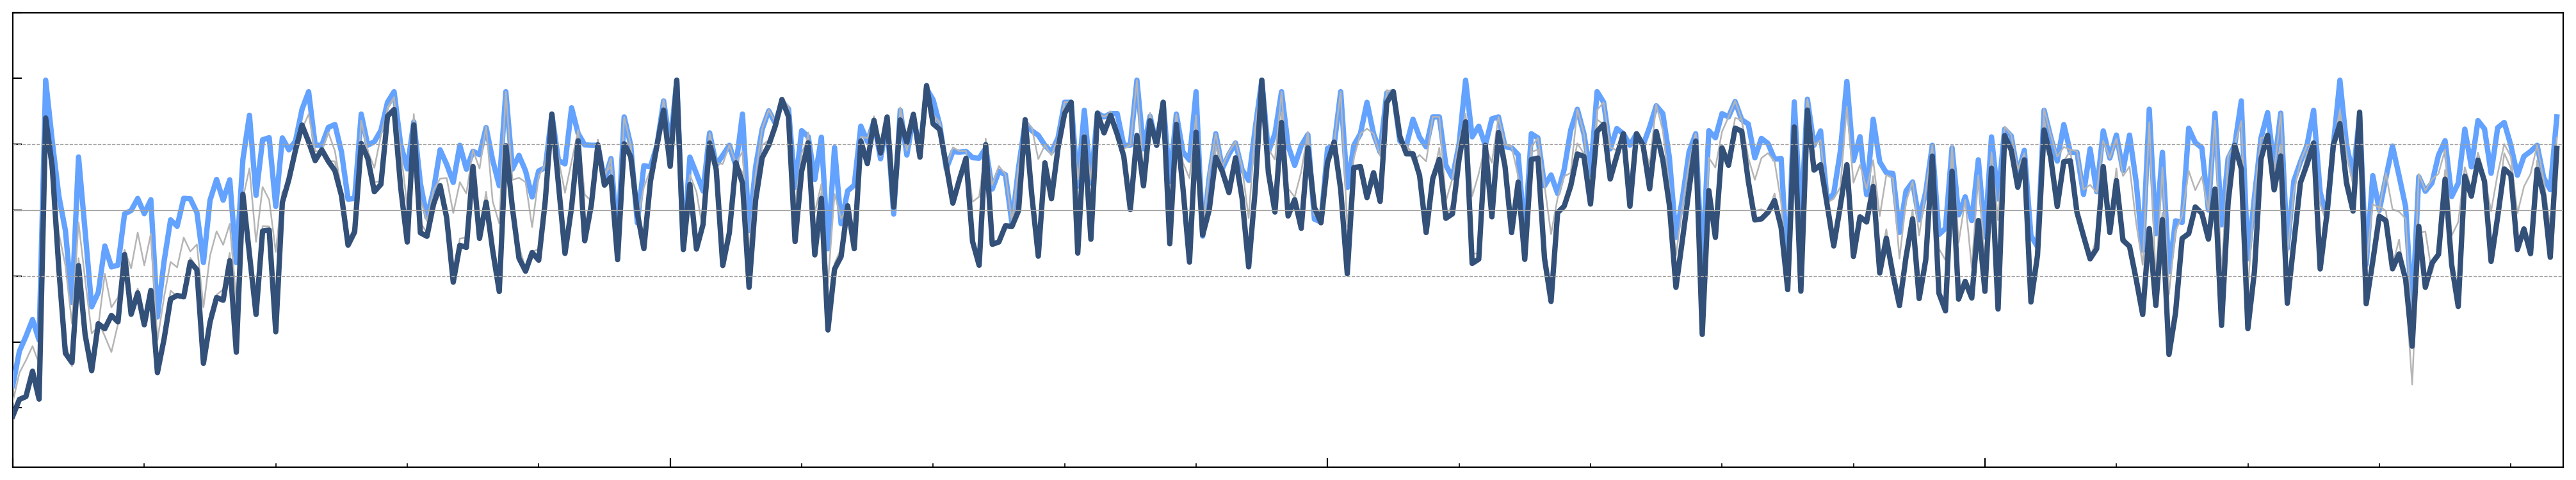

In [27]:
f, (a0) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 3.63), dpi=200)

for i in conserve_list:

    # line
    if i["taxonomy"] == "chordata":
        a0.plot(i["score"], color="#335079", zorder=100, linewidth=3)
    elif i["taxonomy"] == "vertebrata":
        a0.plot(i["score"], color="#b5b5b5", zorder=75, linewidth=0.9)
    elif i["taxonomy"] == "tetrapoda":
        a0.plot(i["score"], color="#b5b5b5", zorder=50, linewidth=0.9)
    elif i["taxonomy"] == "mammalia":
        a0.plot(i["score"], color="#63a2fe", zorder=25, linewidth=3)

#disorder plot
for region in conserve_list[0]["region"]["disorder_region"]:
    start = region["start"]
    start = start / len(conserve_list[0]["human_sequence"])
    end = region["end"]
    end = end / len(conserve_list[0]["human_sequence"])
    a0.axhline(-3, start, end, color="#ff0000", linewidth=3)
    
#0 line
a0.axhline(0 , color="#a2a2a2", linewidth=0.5, zorder=100)
a0.axhline(1 , color="#a2a2a2", linewidth=0.5, linestyle='--', zorder=100)
a0.axhline(-1, color="#a2a2a2", linewidth=0.5, linestyle='--', zorder=100)

#WYF point
for index, (od, aa, score) in enumerate(
    zip(conserve_list[0]["od_ident"], conserve_list[0]["human_sequence"], conserve_list[0]["score"])):
    if od == "1":
        if aa == "Y":
            a0.scatter(index, score, s=200, color="#ffff00", edgecolors="black", linewidths=0.5, zorder=200)
        elif aa == "F":
            a0.scatter(index, score, s=200, color="#ffa300", edgecolors="black", linewidths=0.5, zorder=200)
        elif aa == "W":
            a0.scatter(index, score, s=200, color="#9400d1", edgecolors="black", linewidths=0.5, zorder=200)

#style
a0.set_xlim(0, len(i["score"]))
a0.set_ylim(-3.9, 3)

a0.xaxis.set_major_locator(MultipleLocator(100))
a0.xaxis.set_minor_locator(MultipleLocator(20))
a0.yaxis.set_major_locator(MultipleLocator(1))
# a0.yaxis.set_minor_locator(MultipleLocator(0.5))

a0.tick_params(which='major', axis="x",direction="in", length=5)
a0.tick_params(which='minor', axis="x",direction="in", length=2)
a0.tick_params(which='major', axis="y",direction="in", length=5)
a0.tick_params(which='minor', axis="y",direction="in", length=2)

a0.axes.xaxis.set_ticklabels([])
a0.axes.yaxis.set_ticklabels([])

title = "{} ({})".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"], fontsize=12)
# a0.set_title(title, loc="left")
# a0.set_xlabel("Residue Number", fontsize=12)
# a0.set_ylabel("Conservation Level (Z-score)", fontsize=12)

plt.tight_layout(pad=0.3)

path = Path('/home/wenlin/tmp')
output_path = path / "{}_{}_fig2up".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"])
f.savefig("{}.svg".format(str(output_path)))

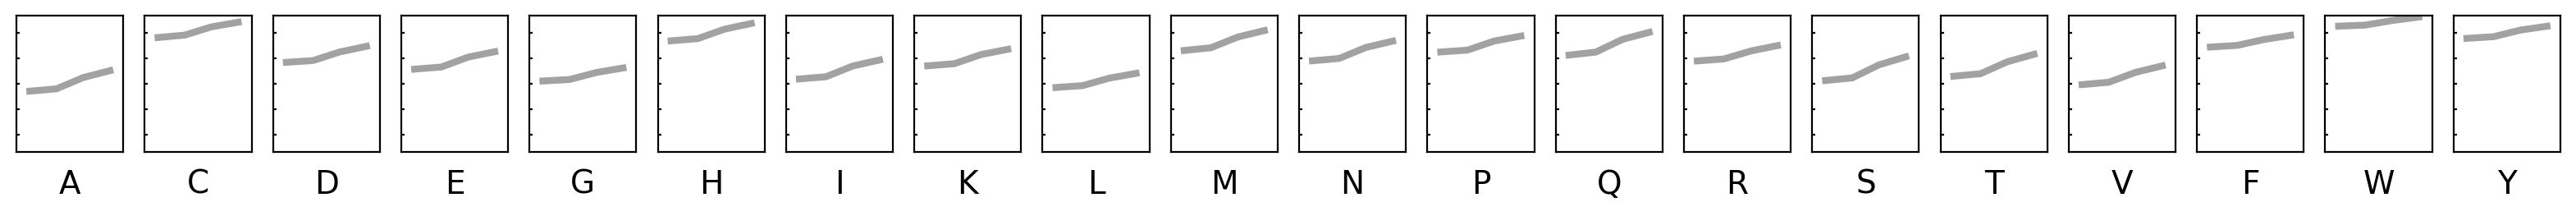

In [29]:
f, (disorder) = plt.subplots(1, 20, sharex=True, sharey=True, figsize=(20, 1.1), dpi=200)

for index, sub in enumerate(disorder):
    sub.plot(order_conserve[index], linestyle="solid", color="#a2a2a2",linewidth=3)
    sub.set_title(conserve_peraa["conserve_peraa_sort"][index], y=-0.4, fontsize=14)
    
    sub.set_xlim(-0.5, 3.5)
    sub.set_ylim(-1.34, 1.34)
    sub.yaxis.set_major_locator(MultipleLocator(0.5))
#     sub.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    sub.tick_params(axis="y", labelsize=14)
    
    sub.axes.yaxis.set_ticklabels([])
    sub.axes.xaxis.set_ticklabels([])
    sub.get_xaxis().set_visible(False)
    
    sub.tick_params(which='major', axis="y",direction="in", length=1.5)
    sub.tick_params(which='minor', axis="y",direction="in", length=1.5)
    

# title = "RBP"
# f.suptitle(title, x=0.16, y=1.2, fontsize=14)

# plt.subplots_adjust(wspace=0.1)
# plt.tight_layout(pad=0.3)

# path = Path('/home/wenlin/tmp')
# output_path = path / "{}_{}_fig2down".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"])
# f.savefig("{}.svg".format(str(output_path)))

In [28]:
order_conserve

array([[-0.14249515, -0.09639005,  0.12500361,  0.26054154],
       [ 0.91156893,  0.95904327,  1.12097247,  1.21194451],
       [ 0.4246745 ,  0.45908305,  0.62808977,  0.7393542 ],
       [ 0.29011953,  0.3319583 ,  0.52584821,  0.63247279],
       [ 0.05775072,  0.08710224,  0.2236194 ,  0.31281474],
       [ 0.84700332,  0.89010881,  1.07603088,  1.18708631],
       [ 0.09787282,  0.14120338,  0.3529203 ,  0.46985231],
       [ 0.35565861,  0.39722285,  0.57735518,  0.67993884],
       [-0.07014455, -0.03329828,  0.11388333,  0.2074726 ],
       [ 0.65706221,  0.71030602,  0.92072259,  1.04838926],
       [ 0.45449832,  0.49973781,  0.71672933,  0.84019882],
       [ 0.62806431,  0.66377048,  0.84254454,  0.9396839 ],
       [ 0.56699512,  0.62459382,  0.87471879,  1.01387991],
       [ 0.45187392,  0.49041416,  0.64612634,  0.75287472],
       [ 0.06724691,  0.11804932,  0.3748155 ,  0.53203726],
       [ 0.15125058,  0.20067596,  0.43462944,  0.58157677],
       [-0.01289771,  0.

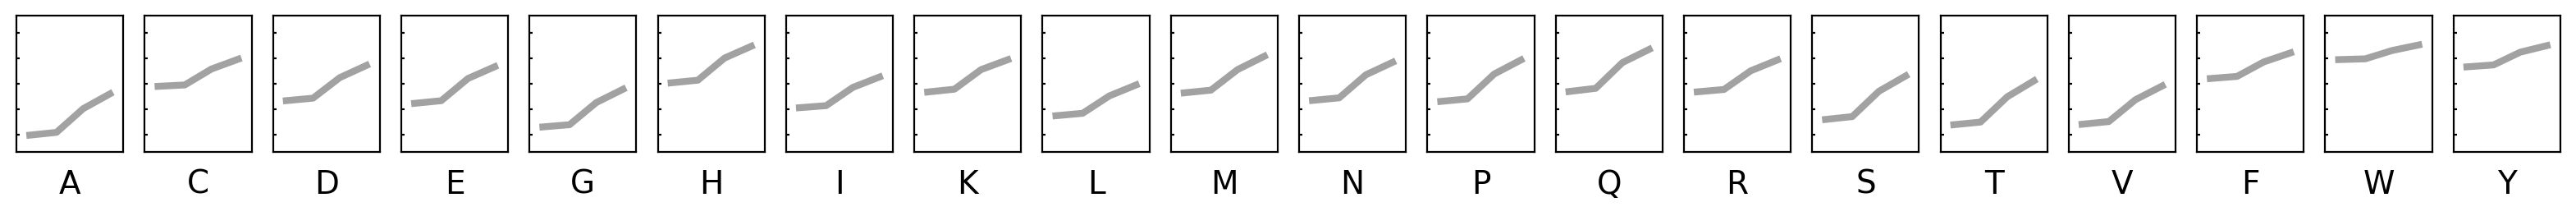

In [33]:
f, (disorder) = plt.subplots(1, 20, sharex=True, sharey=True, figsize=(20, 1.1), dpi=200)

for index, sub in enumerate(disorder):
    sub.plot(order_conserve[index], linestyle="solid", color="#a2a2a2",linewidth=3)
    sub.set_title(conserve_peraa["conserve_peraa_sort"][index], y=-0.4, fontsize=14)
    
    sub.set_xlim(-0.5, 3.5)
    sub.set_ylim(-1.34, 1.34)
    sub.yaxis.set_major_locator(MultipleLocator(0.5))
#     sub.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    sub.tick_params(axis="y", labelsize=14)
    
    sub.axes.yaxis.set_ticklabels([])
    sub.axes.xaxis.set_ticklabels([])
    sub.get_xaxis().set_visible(False)
    
    sub.tick_params(which='major', axis="y",direction="in", length=1.5)
    sub.tick_params(which='minor', axis="y",direction="in", length=1.5)
    

# title = "RBP"
# f.suptitle(title, x=0.16, y=1.2, fontsize=14)

# plt.subplots_adjust(wspace=0.1)
# plt.tight_layout(pad=0.3)

# path = Path('/home/wenlin/tmp')
# output_path = path / "{}_{}_fig2down".format(conserve_list[0]["gene_name"], conserve_list[0]["uniprot_id"])
# f.savefig("{}.svg".format(str(output_path)))